# Recommender with splitted user 

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [2]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [3]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [4]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [5]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [6]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [7]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

# Data pre-processing

In [29]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Base.NonPersonalizedRecommender import TopPop
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from KNN.UserKNNCFRecommender import UserKNNCFRecommender
from KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from KNN.ItemKNNScoresHybridRecommender import ItemKNNScoresHybridRecommender


from GraphBased.RP3betaRecommender_user import RP3betaRecommender_user
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from MatrixFactorization.IALSRecommender import IALSRecommender

MAP_p3aplha_rp3beta_per_group = [0, 0, 0, 0, 0]
MAP_p3aplha_rp3beta_with_als_per_group = [0, 0, 0, 0, 0]
MAP_top_model_als_per_group = [0, 0, 0, 0, 0]
MAP_user_cf_cold_per_group = [0, 0, 0, 0, 0]
MAP_item_cf_cold_per_group = [0, 0, 0, 0, 0]
MAP_item_cbf_per_group = [0, 0, 0, 0, 0]
MAP_top_pop_per_group = [0, 0, 0, 0, 0]
MAP_pure_svd_per_group = [0, 0, 0, 0, 0]
MAP_slim_bpr_per_group = [0, 0, 0, 0, 0]
MAP_top_model_per_group = [0, 0, 0, 0, 0]
cutoff = 10

In [ ]:
for index in range(0, 5):
        URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

        recommender_alpha = P3alphaRecommender(URM_train)
        recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)
        
        recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
        recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
        recommender_beta_ICM.URM_train = URM_train
        
        hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha.W_sparse, recommender_beta_ICM.W_sparse)
        hybridrecommender.fit(topK=200, alpha = 0.1)


        

        recommender_userKNN_top_model = UserKNNCFRecommender(URM_train)
        recommender_userKNN_top_model.fit(topK= 75, shrink = 200)

        recommender_SVD_top_model = PureSVDRecommender(URM_train)
        recommender_SVD_top_model.fit(num_factors = 1200)

        recommender_alpha_top_model = P3alphaRecommender(URM_train)
        recommender_alpha_top_model.fit(topK=350, alpha = 0.45, implicit = True)

        recommender_beta_ICM_top_model = RP3betaRecommender(ICM_all.T)
        recommender_beta_ICM_top_model.fit(topK=70, alpha=0.35, beta=0.4, implicit=False)
        recommender_beta_ICM_top_model.URM_train = URM_train

        hybridrecommender_p3_rp3_top_model = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha_top_model.W_sparse, recommender_beta_ICM_top_model.W_sparse)
        hybridrecommender_p3_rp3_top_model.fit(topK=450, alpha = 0.1)

        hybridrecommender_top_model = ItemKNNScoresHybridMultipleRecommender(URM_train, hybridrecommender_p3_rp3_top_model, recommender_userKNN_top_model, recommender_SVD_top_model)
        hybridrecommender_top_model.fit(alpha = 0.7, beta=0.25)

        grouped_users = dataset.groupby(['row']).count()
        sorted_users = grouped_users.sort_values(by=['col'], ascending=True)
        sorted_users = sorted_users.index.to_numpy()

        block_size = int(len(sorted_users)*0.20)

        for group_id in range(0, 5):
        
                start_pos = group_id*block_size
                end_pos = min((group_id+1)*block_size, len(sorted_users))
                
                users_in_group = sorted_users[start_pos:end_pos]
                
                users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
                users_not_in_group = sorted_users[users_not_in_group_flag]
                
                evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)
                
                results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
                MAP_p3aplha_rp3beta_per_group[group_id] += results[cutoff]["MAP"]
                
                results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender_top_model)
                MAP_top_model_per_group[group_id] += results[cutoff]["MAP"]

In [ ]:
for index in range(0, 5):
    MAP_p3aplha_rp3beta_per_group[index] /= 5
    MAP_p3aplha_rp3beta_with_als_per_group[index] /= 5
    MAP_top_model_als_per_group[index] /= 5
    MAP_top_model_per_group[index] /= 5

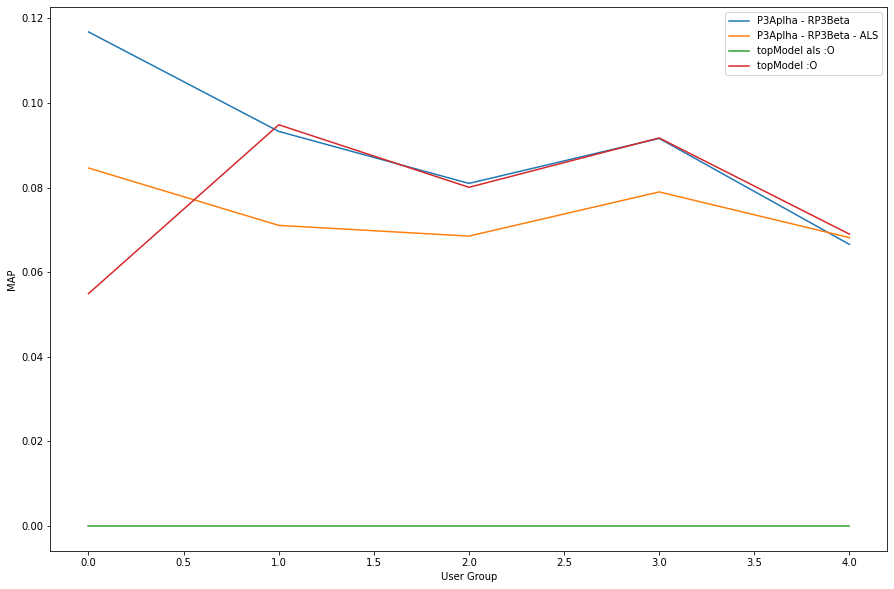

In [32]:
import matplotlib.pyplot as pyplot
%matplotlib inline  
pyplot.figure(figsize=(15,10))
pyplot.plot(MAP_p3aplha_rp3beta_per_group, label="P3Aplha - RP3Beta")
pyplot.plot(MAP_p3aplha_rp3beta_with_als_per_group, label="P3Aplha - RP3Beta - ALS")
pyplot.plot(MAP_top_model_als_per_group, label="topModel als :O")
pyplot.plot(MAP_top_model_per_group, label="topModel :O")

pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()